#  Library-based NMF with Sklearn

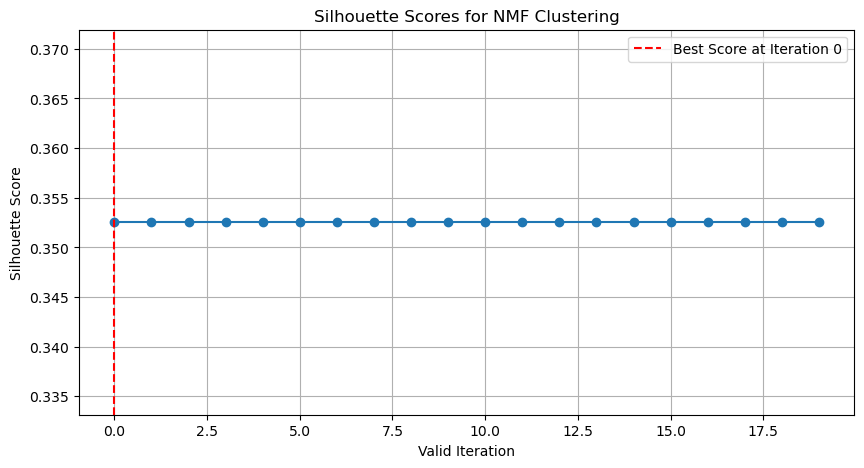

Cluster          0   1   2
Variety                   
Canadian wheat   1  62   7
Kama wheat      17   2  51
Rosa wheat      67   0   3


In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import NMF

# Load the dataset
data = pd.read_csv('seeds.csv')

# Extract grain variety and feature data
varieties = data['grain_variety']
features = data.drop('grain_variety', axis=1) 

# Use MinMaxScaler to scale the data to [0, 1]
scaler = MinMaxScaler()
feature_array = scaler.fit_transform(features)

# Proceed with NMF
rank = 3
repeat_times = 20
silhouette_scores = []
all_labels = []

for i in range(repeat_times):
    model = NMF(n_components=rank, init='nndsvd', random_state=i, max_iter=500)
    W = model.fit_transform(feature_array)
    H = model.components_
    labels = np.argmax(W, axis=1)
    all_labels.append(labels)
    
    # Compute silhouette scores
    score = silhouette_score(feature_array, labels)
    silhouette_scores.append(score)

# Plotting silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(range(len(silhouette_scores)), silhouette_scores, marker='o')
plt.title('Silhouette Scores for NMF Clustering')
plt.xlabel('Valid Iteration')
plt.ylabel('Silhouette Score')
best_score_index = np.argmax(silhouette_scores)
plt.axvline(x=best_score_index, color='r', linestyle='--', label=f'Best Score at Iteration {best_score_index}')
plt.legend()
plt.grid(True)
plt.show()

# Transform the best clustering results into a DataFrame
best_labels = all_labels[best_score_index]
cluster_df = pd.DataFrame({'Variety': varieties, 'Cluster': best_labels})

# Create a crosstab of the varieties and the best clustering results
crosstab_result = pd.crosstab(cluster_df['Variety'], cluster_df['Cluster'])
print(crosstab_result)


# Manual NMF

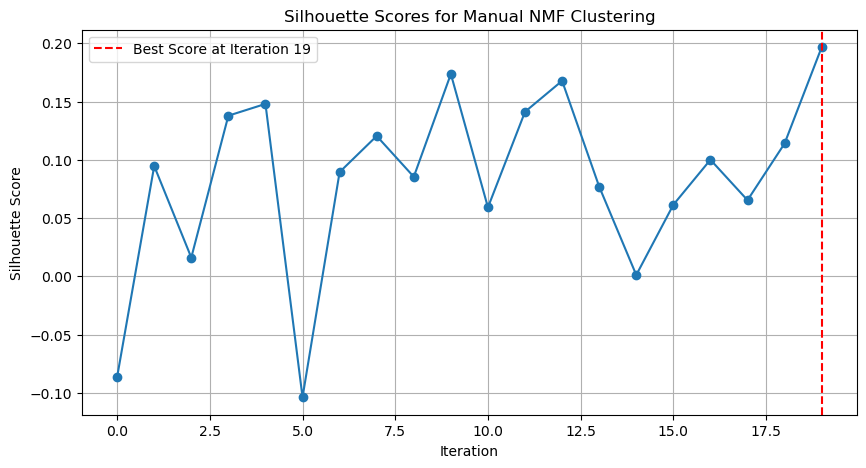

Cluster          0   1   2
Variety                   
Canadian wheat  23  47   0
Kama wheat      35   7  28
Rosa wheat      26   1  43


In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Load the dataset
data = pd.read_csv('seeds.csv')

# 2. Extract grain variety and feature data
varieties = data['grain_variety']  # Extract the grain variety names
features = data.drop('grain_variety', axis=1)  # Remove the variety column to isolate features
V = features.to_numpy()  # Convert dataframe to numpy for processing

# Define the function to update H matrix in NMF
def update_H(W, H, V):
    # Calculate the numerator as the dot product of W transpose and V
    numerator = W.T.dot(V)
    # Calculate the denominator as W transpose, W, and H dot products added with a small constant to avoid division by zero
    denominator = W.T.dot(W).dot(H) + 1e-10
    # Element-wise multiplication of H with the ratio of numerator to denominator
    H = H * (numerator / denominator)
    return H

# Define the function to update W matrix in NMF
def update_W(W, H, V):
    # Calculate the numerator as the dot product of V and H transpose
    numerator = V.dot(H.T)
    # Calculate the denominator as the dot products of W, H, and H transpose added with a small constant to avoid division by zero
    denominator = W.dot(H).dot(H.T) + 1e-10
    # Element-wise multiplication of W with the ratio of numerator to denominator
    W = W * (numerator / denominator)
    return W

# Define the main function to perform custom Non-negative Matrix Factorization
def do_nnmf(V, rank=3, iter=100):
    n, m = V.shape  # Get the dimensions of the input matrix
    # Initialize W and H matrices with absolute values of normally distributed random numbers
    W = np.abs(np.random.randn(1, n, rank))[0]
    H = np.abs(np.random.randn(1, rank, m))[0]
    
    loss = []  # List to store the loss values
    for i in range(iter):  # Iterate the specified number of times
        H = update_H(W, H, V)  # Update H matrix
        W = update_W(W, H, V)  # Update W matrix
        # Calculate the loss as the sum of squared differences between V and the product of W and H
        loss.append(sum((V - W.dot(H)).flatten()**2))
    return H, W, loss  

# 3. Perform NMF' parameters
rank = 3
repeat_times = 20
silhouette_scores = []

for _ in range(repeat_times):
    H, W, loss = do_nnmf(V, rank=rank, iter=100)  # Perform NMF
    labels = np.argmax(W, axis=1)  # Assign labels based on the highest contribution in W
    score = silhouette_score(V, labels)  # Calculate the silhouette score
    silhouette_scores.append(score)  # Store the scores

# 4. Plot the silhouette scores to evaluate clustering quality 
plt.figure(figsize=(10, 5))
plt.plot(range(repeat_times), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Manual NMF Clustering')
plt.xlabel('Iteration')
plt.ylabel('Silhouette Score')
best_score_index = np.argmax(silhouette_scores)  # Find the iteration with the best silhouette score
plt.axvline(x=best_score_index, color='r', linestyle='--', label=f'Best Score at Iteration {best_score_index}')
plt.legend()
plt.grid(True)
plt.show()

# 5. Transform the clustering results corresponding to the best score into a DataFrame and create a crosstab
H, W, loss = do_nnmf(V, rank=rank, iter=100)  # Perform NMF with the best settings
best_labels = np.argmax(W, axis=1)  # Assign labels based on the highest contribution in W
df1 = pd.DataFrame({'Variety': varieties})  # Dataframe of varieties
df2 = pd.DataFrame({'Cluster': best_labels})  # Dataframe of clusters
cross_tab = pd.crosstab(df1['Variety'], df2['Cluster'])  # Create a crosstab of varieties and clusters
print(cross_tab)  # Print the crosstab
